In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import logging

from dataset_reader import dataset_loader
import argparse
import os
from torch.utils.data import DataLoader
import torch
from torch import nn
from torch import Tensor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt



In [26]:

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

# Create the argument parser
parser = argparse.ArgumentParser(description="ASVspoof2021 baseline system")

# Dataset
parser.add_argument(
    "--database_path",
    type=str,
    default="/mnt/c/Users/gabri/Desktop/AVS/DF/",
    help="Change this to user's full directory address of LA database (ASVspoof2019- for training & development (used as validation), ASVspoof2021 for evaluation scores). We assume that all three ASVspoof 2019 LA train, LA dev, and ASVspoof2021 LA eval data folders are in the same database_path directory.",
)
parser.add_argument(
    "--protocols_path",
    type=str,
    default="/mnt/c/Users/gabri/Desktop/AVS/protocols_path/",
    help="Change with path to user's LA database protocols directory address",
)

parser.add_argument(
    "--track", type=str, default="LA", choices=["LA", "PA", "DF"], help="LA/PA/DF"
)
parser.add_argument("--batch_size", type=int, default=256)
parser.add_argument("--model_path", type=str, default=None, help="Model checkpoint")

args = parser.parse_args("--track LA --model_path models/model_vae_mse_sum/epoch_0.pth".split())

In [27]:

track = args.track
# database
prefix = "ASVspoof_{}".format(track)
prefix_2019 = "ASVspoof2019.{}".format(track)

# define train dataloader
d_label_trn, file_train = dataset_loader.genSpoof_list(
    dir_meta=os.path.join(
        args.protocols_path
        + "{}_cm_protocols/{}.cm.train.trn.txt".format(prefix, prefix_2019)
    ),
    is_train=True,
    is_eval=False,
)

print("no. of training trials", len(file_train))

train_set = dataset_loader.Dataset_ASVspoof2019_train(
    args,
    list_IDs=file_train,
    labels=d_label_trn,
    base_dir=os.path.join(
        args.database_path
        + "{}_{}_train/".format(prefix_2019.split(".")[0], args.track)
    ),
    algo=0,
    ae=True,
)

train_loader = DataLoader(
    train_set, batch_size=args.batch_size, num_workers=8, shuffle=True, drop_last=True
)

del train_set, d_label_trn


# define validation dataloader

d_label_dev, file_dev = dataset_loader.genSpoof_list(
    dir_meta=os.path.join(
        args.protocols_path
        + "{}_cm_protocols/{}.cm.dev.trl.txt".format(prefix, prefix_2019)
    ),
    is_train=False,
    is_eval=False,
)

print("no. of validation trials", len(file_dev))

dev_set = dataset_loader.Dataset_ASVspoof2019_train(
    args,
    list_IDs=file_dev,
    labels=d_label_dev,
    base_dir=os.path.join(
        args.database_path + "{}_{}_dev/".format(prefix_2019.split(".")[0], args.track)
    ),
    algo=0,
    ae=True,
)
dev_loader = DataLoader(
    dev_set, batch_size=args.batch_size, num_workers=8, shuffle=False
)
del dev_set, d_label_dev

no. of training trials 25380
no. of validation trials 24844


In [28]:

# make experiment reproducible
# set_random_seed(args.seed, args)

# define model saving path
model_tag = "model_vae_sum_continue"
model_save_path = os.path.join("models", model_tag)

# set model save directory
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

# GPU device
device = "cpu"#"cuda" if torch.cuda.is_available() else "cpu"
print("Device: {}".format(device))


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=640):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=640, z_dim=128, device=None):
        super(VAE, self).__init__()
        self.device = device
        self.encoder = nn.Sequential(  # 1, 1, 128, 253
            nn.Conv2d(image_channels, 4, kernel_size=4, stride=2),  # 1, 32, 63, 125
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size=4, stride=2),  # 1, 64, 30, 61
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2),  # 1, 128, 14, 29
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),  # 1, 256, 6, 13
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),  # 1, 512, 2, 5
            nn.ReLU(),
            Flatten(),
        )

        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)

        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 32, kernel_size=(5, 5), dilation=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=(5, 5), dilation=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=(5, 6), dilation=2, stride=(2, 3)),
            nn.ReLU(),
            nn.ConvTranspose2d(
                8,
                image_channels,
                kernel_size=(6, 5),
                dilation=(3, 2),
                stride=(2, 3),
                padding=(0, 1),
            ),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size(), device=self.device)
        z = mu + std * esp
        return z

    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

model = VAE(image_channels=1, device=device).to(device)

if args.model_path:
    model.load_state_dict(torch.load(args.model_path, map_location=device))
    print("Model loaded : {}".format(args.model_path))

nb_params = sum([param.view(-1).size()[0] for param in model.parameters()])
print("nb_params:", nb_params)

model.eval()

Device: cpu
Model loaded : models/model_vae_mse_sum/epoch_3.pth
nb_params: 819301


VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (9): ReLU()
    (10): Flatten()
  )
  (fc1): Linear(in_features=640, out_features=128, bias=True)
  (fc2): Linear(in_features=640, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=640, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(640, 32, kernel_size=(5, 5), stride=(2, 2), dilation=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2), dilation=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(16, 8, kernel_size=(5, 6), stride=(2, 3), dilation=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(8, 1, kernel_siz

In [29]:
from tqdm import tqdm
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(dev_loader)):
        x = x.view(256, 1, 128, 253)
        x = x.to(device)
        
        x_hat, _, _ = model(x)

        break

  0%|                                                                                            | 0/98 [00:06<?, ?it/s]


In [30]:
#F.mse_loss(batch_out, batch_x, reduction="sum")/256

In [31]:
from matplotlib import pyplot as plt

In [32]:
def show_image(x, idx):
    x = x.view(batch_size, 128, 253)

    fig = plt.figure()
    sample = x[idx].cpu().numpy()
    plt.imshow(sample)
    return sample


In [33]:
batch_size = 256

0.2726615

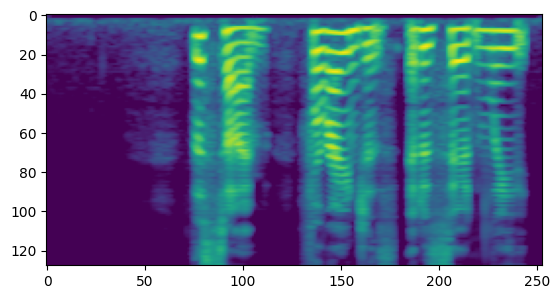

In [34]:
x = show_image(x, 0)
x.mean()

0.033689957

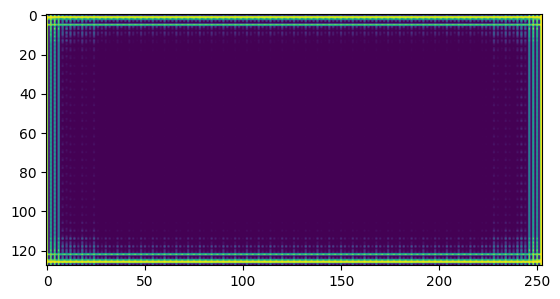

In [35]:
x_hat = show_image(x_hat, 0)
x_hat.mean()

In [36]:
x.max(), x.min(), x_hat.max(), x_hat.min()

(1.0, 0.0, 0.49480888, 0.0)